In [1]:
from __future__ import print_function

In [2]:
pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.0 MB/s 


In [3]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import glob
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

from itertools import chain
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from vit_pytorch.crossformer import CrossFormer

In [6]:
# Training settings
batch_size = 64
epochs = 200
lr = 0.00001
gamma = 0.7
seed = 42

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [8]:
'''
IMAGE CATEGORY ENCODING

Benign = 0
Malignant = 1
'''

'\nIMAGE CATEGORY ENCODING\n\nBenign = 0\nMalignant = 1\n'

In [9]:
from google.colab import drive
drive.mount('/content/drive')

train_list = glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10253', '*', '*.png'))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10254', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10255', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10256', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10257', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10258', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10259', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10260', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10261', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10264', '*', '*.png')))

print(f"Train list length: {len(train_list)}")

Mounted at /content/drive
Train list length: 7906


In [10]:
random.shuffle(train_list)

In [11]:
train_list, test_list = train_test_split(train_list,
                                          test_size=0.15,
                                          random_state=42)

In [12]:
test_list, valid_list = train_test_split(test_list,
                                          test_size=0.33,
                                          random_state=42)

In [13]:
print(f"Train Data: {len(train_list)}")
print(f"Valid Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 6720
Valid Data: 392
Test Data: 794


In [14]:
device = 'cuda'

In [15]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.ToTensor(),
    ]
)

valid_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [16]:
class IDCDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-2].split(".")[0]
        label = 1 if label == "1" else 0

        return img_transformed, label

In [17]:
train_data = IDCDataset(train_list, transform=train_transforms)
valid_data = IDCDataset(valid_list, transform=valid_transforms)
test_data = IDCDataset(test_list, transform=test_transforms)

In [18]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [19]:
model = CrossFormer(
    num_classes = 2,                # number of output classes
    dim = (64, 128, 256, 512),         # dimension at each stage
    depth = (2, 2, 8, 2),              # depth of transformer at each stage
    global_window_size = (8, 4, 2, 1), # global window sizes at each stage
    local_window_size = 7,             # local window size (can be customized for each stage, but in paper, held constant at 7 for all stages)
).to(device)

In [20]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [21]:
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

bestloss = 100
patience = 15
triggers = 0

In [22]:
model.load_state_dict(torch.load("/content/drive/MyDrive/SavedViTModels/CrossFormerSavedModel.pth"))

<All keys matched successfully>

In [23]:
start_time = time.time()

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    model.train()
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss.item() / len(train_loader)

    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss.item() / len(valid_loader)
    
    train_loss_list.append(epoch_loss)
    train_accuracy_list.append(epoch_accuracy)
    val_loss_list.append(epoch_val_loss)
    val_accuracy_list.append(epoch_val_accuracy)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    if(epoch_loss < bestloss):
        triggers = 0
        bestloss = epoch_loss
        #torch.save(model.state_dict(), "/content/drive/MyDrive/SavedViTModels/CrossFormerSavedModel.pth")
        #torch.save(optimizer.state_dict(), "/content/drive/MyDrive/SavedViTModels/CrossFormerSavedOptimizer.pth")
    else:
        triggers += 1

    if triggers == patience:
        print("Early stopping since epoch_loss > bestloss for 15 epochs")
        break

end_time = time.time()

print(f"\nTime taken to train the model: {(end_time - start_time)/60/60} hours")

100%|██████████| 105/105 [1:18:31<00:00, 44.87s/it]


Epoch : 1 - loss : 0.4795 - acc: 0.7746 - val_loss : 0.4623 - val_acc: 0.7612



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 2 - loss : 0.4481 - acc: 0.7887 - val_loss : 0.4525 - val_acc: 0.7768



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 3 - loss : 0.4443 - acc: 0.7917 - val_loss : 0.4315 - val_acc: 0.7768



100%|██████████| 105/105 [02:16<00:00,  1.30s/it]


Epoch : 4 - loss : 0.4458 - acc: 0.7893 - val_loss : 0.4908 - val_acc: 0.7299



100%|██████████| 105/105 [02:16<00:00,  1.30s/it]


Epoch : 5 - loss : 0.4404 - acc: 0.7948 - val_loss : 0.4317 - val_acc: 0.7768



100%|██████████| 105/105 [02:16<00:00,  1.30s/it]


Epoch : 6 - loss : 0.4341 - acc: 0.7972 - val_loss : 0.4771 - val_acc: 0.7612



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 7 - loss : 0.4386 - acc: 0.8007 - val_loss : 0.4014 - val_acc: 0.7790



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 8 - loss : 0.4331 - acc: 0.7963 - val_loss : 0.4817 - val_acc: 0.7455



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 9 - loss : 0.4358 - acc: 0.7985 - val_loss : 0.4976 - val_acc: 0.7455



100%|██████████| 105/105 [02:16<00:00,  1.30s/it]


Epoch : 10 - loss : 0.4382 - acc: 0.7936 - val_loss : 0.4721 - val_acc: 0.7612



100%|██████████| 105/105 [02:16<00:00,  1.30s/it]


Epoch : 11 - loss : 0.4374 - acc: 0.7991 - val_loss : 0.4680 - val_acc: 0.7299



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 12 - loss : 0.4303 - acc: 0.8010 - val_loss : 0.5221 - val_acc: 0.7299



100%|██████████| 105/105 [02:16<00:00,  1.30s/it]


Epoch : 13 - loss : 0.4295 - acc: 0.8009 - val_loss : 0.4216 - val_acc: 0.7924



100%|██████████| 105/105 [02:16<00:00,  1.30s/it]


Epoch : 14 - loss : 0.4293 - acc: 0.7975 - val_loss : 0.4725 - val_acc: 0.7924



100%|██████████| 105/105 [02:16<00:00,  1.30s/it]


Epoch : 15 - loss : 0.4281 - acc: 0.7949 - val_loss : 0.4786 - val_acc: 0.7455



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 16 - loss : 0.4253 - acc: 0.8013 - val_loss : 0.4713 - val_acc: 0.7612



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 17 - loss : 0.4228 - acc: 0.7964 - val_loss : 0.4358 - val_acc: 0.7768



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 18 - loss : 0.4233 - acc: 0.7957 - val_loss : 0.4561 - val_acc: 0.8237



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 19 - loss : 0.4302 - acc: 0.7932 - val_loss : 0.4667 - val_acc: 0.7612



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 20 - loss : 0.4274 - acc: 0.7963 - val_loss : 0.5230 - val_acc: 0.7567



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 21 - loss : 0.4225 - acc: 0.7970 - val_loss : 0.5070 - val_acc: 0.7299



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 22 - loss : 0.4179 - acc: 0.8027 - val_loss : 0.4948 - val_acc: 0.7634



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 23 - loss : 0.4209 - acc: 0.8003 - val_loss : 0.5001 - val_acc: 0.7455



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 24 - loss : 0.4299 - acc: 0.7982 - val_loss : 0.4348 - val_acc: 0.8661



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 25 - loss : 0.4156 - acc: 0.8034 - val_loss : 0.4716 - val_acc: 0.7612



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 26 - loss : 0.4127 - acc: 0.8031 - val_loss : 0.4436 - val_acc: 0.8237



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 27 - loss : 0.4089 - acc: 0.8068 - val_loss : 0.4291 - val_acc: 0.8125



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 28 - loss : 0.3933 - acc: 0.8207 - val_loss : 0.3818 - val_acc: 0.8237



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 29 - loss : 0.3870 - acc: 0.8213 - val_loss : 0.4037 - val_acc: 0.7946



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 30 - loss : 0.3802 - acc: 0.8295 - val_loss : 0.3983 - val_acc: 0.7768



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 31 - loss : 0.3782 - acc: 0.8350 - val_loss : 0.3478 - val_acc: 0.8661



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 32 - loss : 0.3769 - acc: 0.8313 - val_loss : 0.3792 - val_acc: 0.8504



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 33 - loss : 0.3716 - acc: 0.8359 - val_loss : 0.3785 - val_acc: 0.8192



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 34 - loss : 0.3501 - acc: 0.8479 - val_loss : 0.3608 - val_acc: 0.8058



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 35 - loss : 0.3549 - acc: 0.8460 - val_loss : 0.3224 - val_acc: 0.8616



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 36 - loss : 0.3399 - acc: 0.8513 - val_loss : 0.3461 - val_acc: 0.8438



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 37 - loss : 0.3391 - acc: 0.8549 - val_loss : 0.3367 - val_acc: 0.8438



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 38 - loss : 0.3360 - acc: 0.8549 - val_loss : 0.3938 - val_acc: 0.8103



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 39 - loss : 0.3377 - acc: 0.8560 - val_loss : 0.2855 - val_acc: 0.8817



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 40 - loss : 0.3283 - acc: 0.8638 - val_loss : 0.3057 - val_acc: 0.8705



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 41 - loss : 0.3305 - acc: 0.8595 - val_loss : 0.3955 - val_acc: 0.8147



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 42 - loss : 0.3226 - acc: 0.8589 - val_loss : 0.3439 - val_acc: 0.8348



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 43 - loss : 0.3224 - acc: 0.8632 - val_loss : 0.3129 - val_acc: 0.8616



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 44 - loss : 0.3154 - acc: 0.8640 - val_loss : 0.3442 - val_acc: 0.8371



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 45 - loss : 0.3147 - acc: 0.8658 - val_loss : 0.3336 - val_acc: 0.8326



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 46 - loss : 0.3101 - acc: 0.8676 - val_loss : 0.2776 - val_acc: 0.8884



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 47 - loss : 0.3072 - acc: 0.8647 - val_loss : 0.3154 - val_acc: 0.8527



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 48 - loss : 0.3050 - acc: 0.8682 - val_loss : 0.3121 - val_acc: 0.8817



100%|██████████| 105/105 [02:16<00:00,  1.30s/it]


Epoch : 49 - loss : 0.3032 - acc: 0.8659 - val_loss : 0.3112 - val_acc: 0.8549



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 50 - loss : 0.3085 - acc: 0.8686 - val_loss : 0.3138 - val_acc: 0.8415



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 51 - loss : 0.3023 - acc: 0.8690 - val_loss : 0.3002 - val_acc: 0.8683



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 52 - loss : 0.3041 - acc: 0.8693 - val_loss : 0.2949 - val_acc: 0.8527



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 53 - loss : 0.2992 - acc: 0.8708 - val_loss : 0.3206 - val_acc: 0.8549



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 54 - loss : 0.3067 - acc: 0.8677 - val_loss : 0.3148 - val_acc: 0.8438



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 55 - loss : 0.3006 - acc: 0.8723 - val_loss : 0.3010 - val_acc: 0.8594



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 56 - loss : 0.2958 - acc: 0.8759 - val_loss : 0.2784 - val_acc: 0.8884



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 57 - loss : 0.2949 - acc: 0.8768 - val_loss : 0.2776 - val_acc: 0.8795



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 58 - loss : 0.2906 - acc: 0.8780 - val_loss : 0.3057 - val_acc: 0.8482



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 59 - loss : 0.2982 - acc: 0.8768 - val_loss : 0.3287 - val_acc: 0.8348



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 60 - loss : 0.2910 - acc: 0.8732 - val_loss : 0.3123 - val_acc: 0.8504



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 61 - loss : 0.2947 - acc: 0.8769 - val_loss : 0.2920 - val_acc: 0.8594



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 62 - loss : 0.2912 - acc: 0.8802 - val_loss : 0.2886 - val_acc: 0.8683



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 63 - loss : 0.2904 - acc: 0.8762 - val_loss : 0.2918 - val_acc: 0.8616



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 64 - loss : 0.2982 - acc: 0.8760 - val_loss : 0.2827 - val_acc: 0.8728



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 65 - loss : 0.2807 - acc: 0.8821 - val_loss : 0.2863 - val_acc: 0.8929



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 66 - loss : 0.2905 - acc: 0.8766 - val_loss : 0.3198 - val_acc: 0.8594



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 67 - loss : 0.2941 - acc: 0.8757 - val_loss : 0.3114 - val_acc: 0.8750



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 68 - loss : 0.2879 - acc: 0.8754 - val_loss : 0.3271 - val_acc: 0.8460



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 69 - loss : 0.2902 - acc: 0.8786 - val_loss : 0.3091 - val_acc: 0.8594



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 70 - loss : 0.2861 - acc: 0.8807 - val_loss : 0.2873 - val_acc: 0.8638



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 71 - loss : 0.2845 - acc: 0.8763 - val_loss : 0.3051 - val_acc: 0.8571



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 72 - loss : 0.2782 - acc: 0.8805 - val_loss : 0.2727 - val_acc: 0.8817



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 73 - loss : 0.2813 - acc: 0.8821 - val_loss : 0.2546 - val_acc: 0.8929



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 74 - loss : 0.2854 - acc: 0.8811 - val_loss : 0.2547 - val_acc: 0.8951



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 75 - loss : 0.2801 - acc: 0.8795 - val_loss : 0.2934 - val_acc: 0.8571



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 76 - loss : 0.2786 - acc: 0.8813 - val_loss : 0.2457 - val_acc: 0.8996



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 77 - loss : 0.2805 - acc: 0.8804 - val_loss : 0.2378 - val_acc: 0.8929



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 78 - loss : 0.2783 - acc: 0.8848 - val_loss : 0.3301 - val_acc: 0.8683



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 79 - loss : 0.2746 - acc: 0.8833 - val_loss : 0.3059 - val_acc: 0.8839



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 80 - loss : 0.2762 - acc: 0.8808 - val_loss : 0.3009 - val_acc: 0.8616



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 81 - loss : 0.2677 - acc: 0.8868 - val_loss : 0.2909 - val_acc: 0.8862



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 82 - loss : 0.2702 - acc: 0.8872 - val_loss : 0.2372 - val_acc: 0.9018



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 83 - loss : 0.2783 - acc: 0.8820 - val_loss : 0.3272 - val_acc: 0.8438



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 84 - loss : 0.2754 - acc: 0.8839 - val_loss : 0.2544 - val_acc: 0.9107



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 85 - loss : 0.2758 - acc: 0.8807 - val_loss : 0.2473 - val_acc: 0.9129



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 86 - loss : 0.2720 - acc: 0.8878 - val_loss : 0.2988 - val_acc: 0.8661



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 87 - loss : 0.2727 - acc: 0.8838 - val_loss : 0.2862 - val_acc: 0.8705



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 88 - loss : 0.2711 - acc: 0.8859 - val_loss : 0.2772 - val_acc: 0.8795



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 89 - loss : 0.2724 - acc: 0.8845 - val_loss : 0.2454 - val_acc: 0.8973



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 90 - loss : 0.2684 - acc: 0.8868 - val_loss : 0.2515 - val_acc: 0.8951



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 91 - loss : 0.2714 - acc: 0.8868 - val_loss : 0.2368 - val_acc: 0.9196



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 92 - loss : 0.2666 - acc: 0.8872 - val_loss : 0.2576 - val_acc: 0.9018



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 93 - loss : 0.2711 - acc: 0.8859 - val_loss : 0.2416 - val_acc: 0.9129



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 94 - loss : 0.2681 - acc: 0.8850 - val_loss : 0.2537 - val_acc: 0.8906



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 95 - loss : 0.2766 - acc: 0.8838 - val_loss : 0.3378 - val_acc: 0.8549



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 96 - loss : 0.2719 - acc: 0.8820 - val_loss : 0.2645 - val_acc: 0.8973



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 97 - loss : 0.2703 - acc: 0.8844 - val_loss : 0.2941 - val_acc: 0.8884



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 98 - loss : 0.2678 - acc: 0.8881 - val_loss : 0.2472 - val_acc: 0.8862



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 99 - loss : 0.2662 - acc: 0.8887 - val_loss : 0.2233 - val_acc: 0.8951



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 100 - loss : 0.2642 - acc: 0.8869 - val_loss : 0.3287 - val_acc: 0.8728



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 101 - loss : 0.2666 - acc: 0.8891 - val_loss : 0.2323 - val_acc: 0.8929



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 102 - loss : 0.2654 - acc: 0.8856 - val_loss : 0.2682 - val_acc: 0.8772



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 103 - loss : 0.2596 - acc: 0.8902 - val_loss : 0.2398 - val_acc: 0.8996



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 104 - loss : 0.2648 - acc: 0.8868 - val_loss : 0.2579 - val_acc: 0.8750



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 105 - loss : 0.2670 - acc: 0.8868 - val_loss : 0.2865 - val_acc: 0.8661



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 106 - loss : 0.2556 - acc: 0.8945 - val_loss : 0.2290 - val_acc: 0.8884



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 107 - loss : 0.2649 - acc: 0.8902 - val_loss : 0.2541 - val_acc: 0.8638



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 108 - loss : 0.2619 - acc: 0.8878 - val_loss : 0.2403 - val_acc: 0.8839



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 109 - loss : 0.2620 - acc: 0.8908 - val_loss : 0.2562 - val_acc: 0.8951



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 110 - loss : 0.2601 - acc: 0.8891 - val_loss : 0.2118 - val_acc: 0.9174



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 111 - loss : 0.2651 - acc: 0.8874 - val_loss : 0.2779 - val_acc: 0.8638



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 112 - loss : 0.2585 - acc: 0.8927 - val_loss : 0.2146 - val_acc: 0.9107



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 113 - loss : 0.2627 - acc: 0.8927 - val_loss : 0.2490 - val_acc: 0.8750



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 114 - loss : 0.2579 - acc: 0.8949 - val_loss : 0.2692 - val_acc: 0.8884



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 115 - loss : 0.2549 - acc: 0.8914 - val_loss : 0.2854 - val_acc: 0.8884



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 116 - loss : 0.2596 - acc: 0.8926 - val_loss : 0.2441 - val_acc: 0.8906



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 117 - loss : 0.2586 - acc: 0.8888 - val_loss : 0.2583 - val_acc: 0.8973



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 118 - loss : 0.2524 - acc: 0.8948 - val_loss : 0.2480 - val_acc: 0.8750



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 119 - loss : 0.2548 - acc: 0.8926 - val_loss : 0.2703 - val_acc: 0.8951



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 120 - loss : 0.2526 - acc: 0.8938 - val_loss : 0.2669 - val_acc: 0.8929



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 121 - loss : 0.2570 - acc: 0.8920 - val_loss : 0.2807 - val_acc: 0.8571



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 122 - loss : 0.2572 - acc: 0.8909 - val_loss : 0.2321 - val_acc: 0.8929



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 123 - loss : 0.2534 - acc: 0.8927 - val_loss : 0.2374 - val_acc: 0.9107



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 124 - loss : 0.2587 - acc: 0.8923 - val_loss : 0.2149 - val_acc: 0.9263



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 125 - loss : 0.2555 - acc: 0.8948 - val_loss : 0.2136 - val_acc: 0.9152



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 126 - loss : 0.2548 - acc: 0.8942 - val_loss : 0.2257 - val_acc: 0.9063



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 127 - loss : 0.2511 - acc: 0.8923 - val_loss : 0.2253 - val_acc: 0.9018



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 128 - loss : 0.2531 - acc: 0.8936 - val_loss : 0.2675 - val_acc: 0.8839



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 129 - loss : 0.2496 - acc: 0.8948 - val_loss : 0.2123 - val_acc: 0.9129



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 130 - loss : 0.2529 - acc: 0.8952 - val_loss : 0.2515 - val_acc: 0.9063



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 131 - loss : 0.2395 - acc: 0.8984 - val_loss : 0.2444 - val_acc: 0.8906



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 132 - loss : 0.2537 - acc: 0.8938 - val_loss : 0.1962 - val_acc: 0.9219



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 133 - loss : 0.2525 - acc: 0.8932 - val_loss : 0.2195 - val_acc: 0.9174



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 134 - loss : 0.2506 - acc: 0.8979 - val_loss : 0.2886 - val_acc: 0.8772



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 135 - loss : 0.2515 - acc: 0.8967 - val_loss : 0.2255 - val_acc: 0.9174



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 136 - loss : 0.2468 - acc: 0.8963 - val_loss : 0.3159 - val_acc: 0.8661



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 137 - loss : 0.2480 - acc: 0.8948 - val_loss : 0.2518 - val_acc: 0.8817



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 138 - loss : 0.2525 - acc: 0.8964 - val_loss : 0.2477 - val_acc: 0.8862



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 139 - loss : 0.2444 - acc: 0.9004 - val_loss : 0.2522 - val_acc: 0.8772



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 140 - loss : 0.2465 - acc: 0.8988 - val_loss : 0.2324 - val_acc: 0.8906



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 141 - loss : 0.2512 - acc: 0.8966 - val_loss : 0.2229 - val_acc: 0.9040



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 142 - loss : 0.2473 - acc: 0.8969 - val_loss : 0.2151 - val_acc: 0.9085



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 143 - loss : 0.2508 - acc: 0.8973 - val_loss : 0.2462 - val_acc: 0.8772



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 144 - loss : 0.2450 - acc: 0.8991 - val_loss : 0.2374 - val_acc: 0.8884



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 145 - loss : 0.2487 - acc: 0.8988 - val_loss : 0.2366 - val_acc: 0.8951



100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


Epoch : 146 - loss : 0.2485 - acc: 0.8973 - val_loss : 0.2027 - val_acc: 0.9174

Early stopping since epoch_loss > bestloss for 15 epochs

Time taken to train the model: 6.944048695299361 hours


In [24]:
print("train_loss: ")
print(np.asarray(torch.Tensor(train_loss_list).cpu()))
print("train_acc: ")
print(np.asarray(torch.Tensor(train_accuracy_list).cpu()))
print("val_loss: ")
print(np.asarray(torch.Tensor(val_loss_list).cpu()))
print("val_acc: ")
print(np.asarray(torch.Tensor(val_accuracy_list).cpu()))

train_loss: 
[0.4795374  0.4481024  0.44434682 0.44580758 0.44043317 0.43406296
 0.43860576 0.43305242 0.4357778  0.4382341  0.43735066 0.43033364
 0.42949843 0.4293348  0.4281255  0.42533246 0.42281988 0.42325953
 0.4302372  0.42744583 0.42249992 0.4178617  0.4208749  0.42994708
 0.41564295 0.41269267 0.40893677 0.39326417 0.38698393 0.3802213
 0.3781513  0.37688577 0.37161556 0.35012442 0.3549275  0.33988705
 0.33908537 0.33601072 0.33769286 0.32830283 0.33047804 0.32258135
 0.32240668 0.3154063  0.31468588 0.31006247 0.3072427  0.304983
 0.30315414 0.30850744 0.30230442 0.30410507 0.29915765 0.3067392
 0.3005974  0.29582328 0.29488897 0.2905823  0.298162   0.29098922
 0.2946616  0.29117796 0.29038426 0.29820895 0.28073457 0.2904549
 0.29408696 0.28786215 0.29023063 0.2860756  0.28450814 0.27821827
 0.28131482 0.28535676 0.28010777 0.2786326  0.28045347 0.2782926
 0.27460322 0.2761562  0.26768118 0.27018553 0.2783462  0.2754474
 0.275782   0.27201506 0.27265793 0.271071   0.2724437  

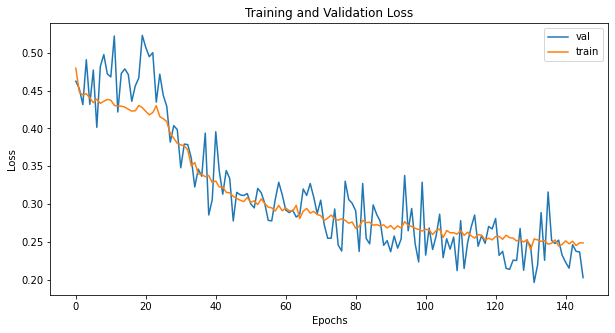

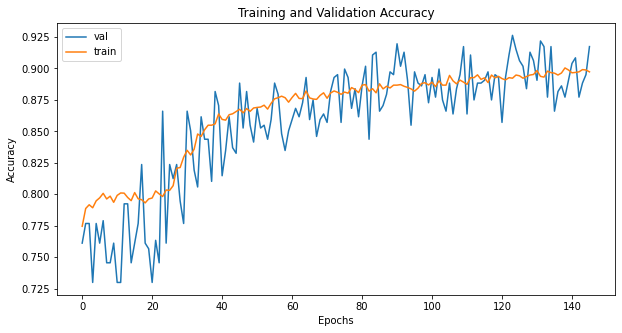

In [25]:
#Checking for overfitting/underfitting
val_loss_list = torch.from_numpy(np.asarray(torch.Tensor(val_loss_list).cpu()))
train_loss_list = torch.from_numpy(np.asarray(torch.Tensor(train_loss_list).cpu()))
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_loss_list,label="val")
plt.plot(train_loss_list,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

val_accuracy_list = torch.from_numpy(np.asarray(torch.Tensor(val_accuracy_list).cpu()))
train_accuracy_list = torch.from_numpy(np.asarray(torch.Tensor(train_accuracy_list).cpu()))
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracy_list,label="val")
plt.plot(train_accuracy_list,label="train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [26]:
actual_labels = []
predicted_labels = []

In [27]:
#Test accuracy
model.eval()
with torch.no_grad():
        test_accuracy = []
        
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            
            actual_labels.extend(np.asarray(label.cpu()).tolist())

            t_output = model(data)
            t_loss = criterion(t_output, label)
            
            predicted_labels.extend(np.asarray(t_output.argmax(dim=1).cpu()).tolist())

            acc = (t_output.argmax(dim=1) == label).float().mean()
            test_accuracy.append(acc)

        final_test_accuracy = sum(test_accuracy)/len(test_accuracy)
        print(f"test_acc : {final_test_accuracy:.4f}\n")

test_acc : 0.9039



In [28]:
print("Actual labels: ")
print(actual_labels)
print("Predicted labels: ")
print(predicted_labels)

Actual labels: 
[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in the model = {count_parameters(model)}")

Number of trainable parameters in the model = 28268766


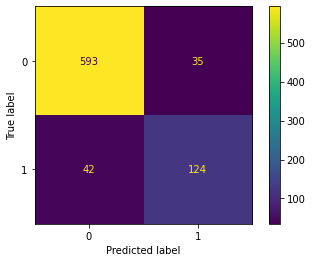

In [30]:
#Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cnf_matrix = confusion_matrix(actual_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)

disp.plot()
plt.show()

In [31]:
#Specificity
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - cnf_matrix.sum(axis=0) - cnf_matrix.sum(axis=1) + np.diag(cnf_matrix)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

TNR = TN/(TN+FP)

print(f"Class wise specificity:")
print(f"Specificity = {TNR}\n")

print(f"Average specificity:")
print(f"Specificity = {np.average(np.array(TNR))}\n")

Class wise specificity:
Specificity = [0.74698795 0.94426752]

Average specificity:
Specificity = 0.8456277338653979



In [32]:
#Accuracy, Sensitivity, Precision, F1 score
from sklearn.metrics import classification_report

target_names = ['0', '1']
print(classification_report(actual_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       628
           1       0.78      0.75      0.76       166

    accuracy                           0.90       794
   macro avg       0.86      0.85      0.85       794
weighted avg       0.90      0.90      0.90       794



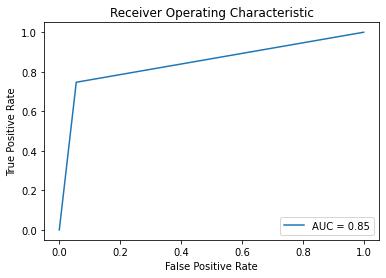

In [33]:
#ROC curve
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(actual_labels, predicted_labels)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [34]:
#AUC
print(f"AUC = {roc_auc}")

AUC = 0.8456277338653979
